In [ ]:
import os
import sys
package = os.path.abspath("../../")
sys.path.insert(0, package)
from qflux.data.config import load_config_from_yaml
from qflux.data.dataset import ImageDataset, loader
from matplotlib import pyplot as plt
import numpy as np
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.INFO)
logging.info('info')

/home/lilong/.local/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
INFO:root:info


In [2]:
import logging, sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s: %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
    force=True,  # 关键：覆盖已有配置
)
logger = logging.getLogger(__name__)
logger.info("it works")

2025-09-27 17:58:18,043 | INFO | __main__: it works


In [3]:
logging.info('info')

2025-09-27 17:58:18,048 | INFO | root: info


# face segmentation

In [4]:
config_file='../../configs/example_fluxkontext_fp16.yaml'
config_file="/mnt/nas/public2/lilong/repos/qwen-image-finetune/configs/flux_kontext_ktp/ktp_flux_kontext_fp16_control2.yaml"
config_file='../../configs/local_examples/ktp_flux_kontext_fp16_all_field_reference.yaml'
config_file = "../../tests/test_configs/test_example_qwen_image_edit_plus_fp4_dynamic_shapes.yaml"
config_file = os.path.abspath(config_file)
config = load_config_from_yaml(config_file)


In [5]:
config

Config(trainer=<TrainerKind.QwenImageEditPlus: 'QwenImageEditPlus'>, resume=None, mode=<TrMode.predict: 'predict'>, model=ModelConfig(pretrained_model_name_or_path='ovedrive/Qwen-Image-Edit-2509-4bit', pretrained_embeddings=None, lora=LoraConfig(r=16, lora_alpha=16, init_lora_weights='gaussian', target_modules=['to_k', 'to_q', 'to_v', 'to_out.0'], pretrained_weight=None, adapter_name='lora_edit'), quantize=False), data=DataConfig(class_path='src.data.dataset.ImageDataset', init_args=DatasetInitArgs(dataset_path=[{'repo_id': 'TsienDragon/face_segmentation_20', 'split': 'train'}], caption_dropout_rate=0.0, prompt_image_dropout_rate=0.0, cache_dir='/tmp/image_edit_lora/faceSegQwenImageEditPlusFp4DynamicShapes/cache', use_cache=True, use_edit_mask=True, selected_control_indexes=[1], prompt_empty_drop_keys=['prompt_embeds', 'pooled_prompt_embeds'], processor=ImageProcessorConfig(class_path='src.data.preprocess.ImageProcessor', init_args=ImageProcessorInitArgs(process_type='fixed_pixels', re

In [6]:
data_init_args = config.data.init_args
dataset = ImageDataset(data_init_args)

缓存已启用，缓存目录: /tmp/image_edit_lora/faceSegQwenImageEditPlusFp4DynamicShapes/cache
2025-09-27 17:58:24,620 | INFO | root: Loaded Hugging Face dataset: TsienDragon/face_segmentation_20, {'type': 'huggingface', 'repo_id': 'TsienDragon/face_segmentation_20', 'dataset': Dataset({
    features: ['id', 'control_images', 'control_mask', 'target_image', 'prompt'],
    num_rows: 20
}), 'length': 20, 'start_idx': 0}
2025-09-27 17:58:24,661 | INFO | root: ImageProcessor initialized with target_size: Nonecontrols_size: None


In [7]:
data_init_args.processor.init_args

ImageProcessorInitArgs(process_type='fixed_pixels', resize_mode='bilinear', target_size=None, controls_size=None, controls_pixels=[262144], target_pixels=262144)

In [8]:
data_init_args.use_cache

True

In [9]:
dataset.preprocessor.target_size, dataset.preprocessor.controls_size

(None, None)

In [10]:
dataset.preprocessor.target_pixels, dataset.preprocessor.controls_pixels

(262144, [262144])

In [11]:
262144

262144

In [13]:
1365/1024

1.3330078125

In [ ]:
262144

8192.0

In [ ]:
448*576, 262144

In [12]:
data = dataset[0]

original w,h 1024 1365
new shape 448 576 target_pixels 262144


AssertionError: new_w * new_h 258048 != target_pixels 262144

In [ ]:
def map_mask_to_latent(image_mask: Tensor) -> Tensor:
    """
    Args:
        image_mask: [B, H, W] - Binary mask in image space
    Returns:
        latent_mask: [B, seq_len] - Weights for packed latent
    """
    B, H, W = image_mask.shape

    # Step 1: VAE-aligned downsampling
    # [B, H, W] → [B, H/8, W/8]
    latent_h, latent_w = H // 8, W // 8
    mask_latent = F.avg_pool2d(
        image_mask.float().unsqueeze(1),
        kernel_size=8, stride=8
    ).squeeze(1)  # [B, latent_h, latent_w]

    # Step 2: Packing simulation
    # [B, latent_h, latent_w] → [B, latent_h//2, latent_w//2, 4]
    # First reshape to separate 2x2 patches, then fold
    patches = mask_latent.reshape(B, latent_h//2, 2, latent_w//2, 2)
    patches = patches.permute(0, 1, 3, 2, 4).contiguous().view(B, latent_h//2, latent_w//2, 4)

    # Step 3: Patch-wise maximum (preserve text regions)
    # [B, latent_h//2, latent_w//2, 4] → [B, latent_h//2, latent_w//2]
    packed_mask = patches.max(dim=-1)[0]

    # Step 4: Flatten to sequence
    # [B, latent_h//2, latent_w//2] → [B, seq_len]
    seq_len = (latent_h // 2) * (latent_w // 2)
    return packed_mask.view(B, seq_len)

In [13]:
262144 - 258048

4096

In [ ]:
data.keys()

NameError: name 'data' is not defined

In [50]:
data['control'].shape

torch.Size([3, 576, 832])

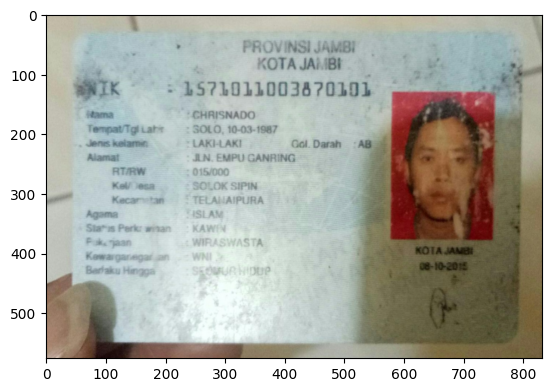

In [51]:
plt.imshow((data['image']*255).numpy().astype(np.uint8).transpose(1, 2, 0))


In [52]:
data.keys()

dict_keys(['image', 'control', 'mask', 'prompt', 'file_hashes', 'cached', 'control_1', 'n_controls'])

In [53]:
data['control'].shape

torch.Size([3, 576, 832])

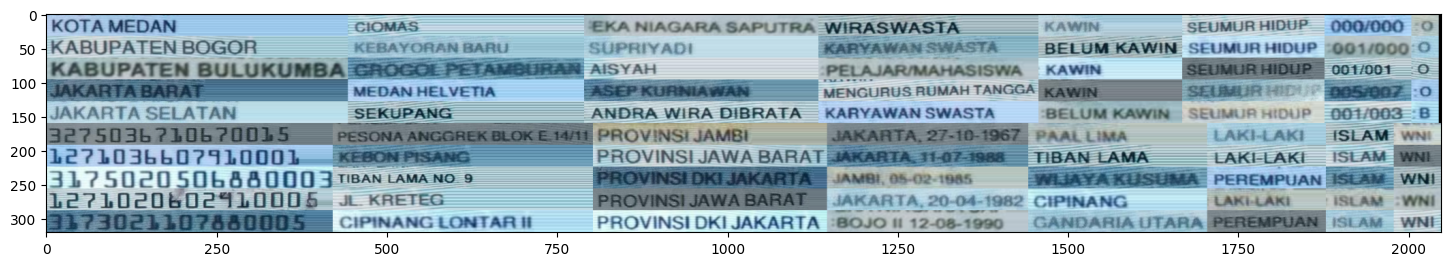

In [55]:
plt.figure(figsize=(18, 10))

plt.imshow((data['control_1']*255).numpy().astype(np.uint8).transpose(1, 2, 0))


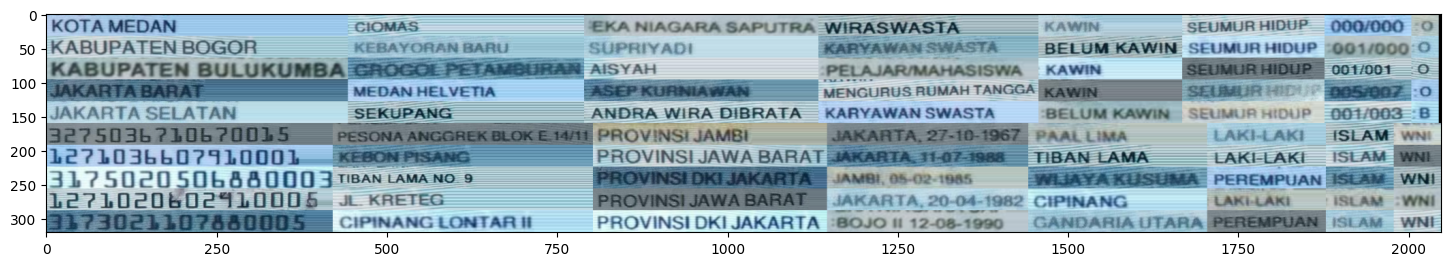

In [42]:
plt.figure(figsize=(18, 10))
plt.imshow((data['control_2']*255).numpy().astype(np.uint8).transpose(1, 2, 0))


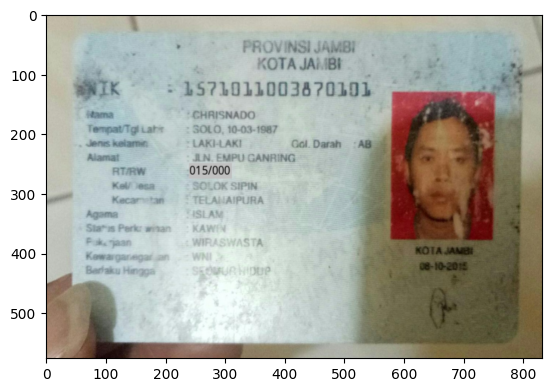

In [26]:
plt.imshow((data['control']*255).numpy().astype(np.uint8).transpose(1, 2, 0))


In [27]:
data['mask'].shape

torch.Size([576, 832])

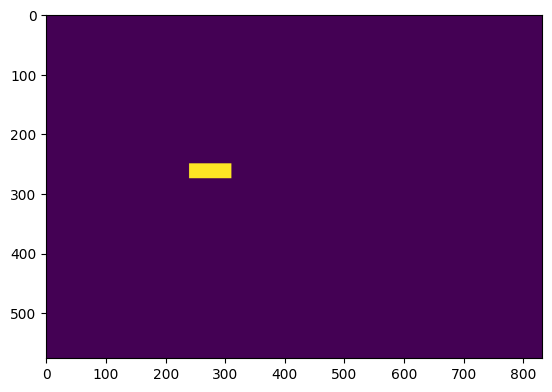

In [28]:
plt.imshow((data['mask']).numpy().astype(np.uint8))


In [12]:
data['cached']

False

In [13]:
data['prompt']

'Replace the colored blocks to corresponding text as indicated in the following json data for realistic text rendering.\nFor each block, render text using the font style indicated by the `style_token`.\n--- BEGIN JSON ---\n{\n  "blocks": [\n    {\n      "idx": "NIK",\n      "field_id": "nik",\n      "style_token": "<f_nik>",\n      "color": "blue",\n      "text": "3603271709860003",\n      "chars": ["3","6","0","3","2","7","1","7","0","9","8","6","0","0","0","3"],\n      "lang": "Indonesian"\n    },\n    {\n      "idx": "PLACE_BIRTHDAY",\n      "field_id": "place_birthday",\n      "style_token": "<f_place_birthday>",\n      "color": "olive",\n      "text": "TANGERANG. 17-09-1986",\n      "chars": ["T","A","N","G","E","R","A","N","G",".","","1","7","-","0","9","-","1","9","8","6"],\n      "lang": "Indonesian"\n    },\n    {\n      "idx": "VILLAGE",\n      "field_id": "village",\n      "style_token": "<f_village>",\n      "color": "pink",\n      "text": "MERAK",\n      "chars": ["M","E",

In [13]:
dataloader = loader(
        class_path=config.data.class_path,
        init_args=config.data.init_args,
        batch_size=config.data.batch_size,
        num_workers=config.data.num_workers,
        shuffle=config.data.shuffle
    )

缓存已启用，缓存目录: /tmp/image_edit_lora/cache


In [14]:
for batch in dataloader:
    break

In [15]:
batch['image'].shape, batch['control'].shape, batch['prompt']


(torch.Size([8, 3, 832, 576]),
 torch.Size([8, 3, 832, 576]),
 ['change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask'])

In [16]:
batch['file_hashes']

{'image_hash': ['e9c716b85125fc46',
  'b48fc38f3cb062a3',
  'adf052cbdc6e2072',
  'bdb0d2cf8b3c8c50',
  'bdad70b6b0703c92',
  'f09e439cc638a753',
  'abd8e3858f6cb490',
  'bdd0c2cd0fae302b'],
 'control_hash': ['e9e69eb8612d6446',
  '98a4a3cb5c2c726f',
  'fdd2028fb22e2953',
  'bd80c22fd22cd9f8',
  'bfed3c32607ca403',
  'cf6bb0418b464cb7',
  'eef8732586267494',
  '9df250cf0e3c303b'],
 'prompt_hash': ['0115e5112de481e4a8f7b25dfabc29d5',
  '0115e5112de481e4a8f7b25dfabc29d5',
  '0115e5112de481e4a8f7b25dfabc29d5',
  '0115e5112de481e4a8f7b25dfabc29d5',
  '0115e5112de481e4a8f7b25dfabc29d5',
  '0115e5112de481e4a8f7b25dfabc29d5',
  '0115e5112de481e4a8f7b25dfabc29d5',
  '0115e5112de481e4a8f7b25dfabc29d5'],
 'empty_prompt_hash': ['a2e4822a98337283e39f7b60acf85ec9',
  'a2e4822a98337283e39f7b60acf85ec9',
  'a2e4822a98337283e39f7b60acf85ec9',
  'a2e4822a98337283e39f7b60acf85ec9',
  'a2e4822a98337283e39f7b60acf85ec9',
  'a2e4822a98337283e39f7b60acf85ec9',
  'a2e4822a98337283e39f7b60acf85ec9',
  'a2e482

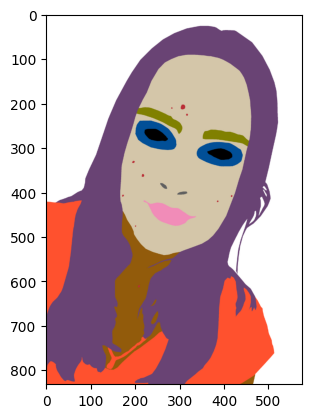

In [29]:
image = batch['image'][6]
image = image.numpy().transpose(1, 2, 0)
image = image*255
image = image.astype(np.uint8)
image.shape
plt.imshow(image)
plt.show()


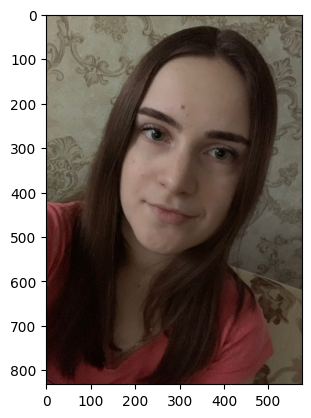

In [30]:
image = batch['control'][6]
image = image.numpy().transpose(1, 2, 0)
image = image*255
image = image.astype(np.uint8)
image.shape
plt.imshow(image)
plt.show()

# multi-controls

In [4]:
# config_file='../../configs/ktp_flux_kontext_fp16.yaml'
# config_file='/mnt/nas/public2/lilong/repos/qwen-image-finetune/configs/flux_kontext_ktp/ktp_flux_kontext_fp16.yaml'
config_file='../../tests/test_configs/test_example_fluxkontext_fp16_character_composition.yaml'
config_file = os.path.abspath(config_file)
config = load_config_from_yaml(config_file)

In [5]:
config

Config(trainer=<TrainerKind.FluxKontext: 'FluxKontext'>, resume=None, mode=<TrMode.predict: 'predict'>, model=ModelConfig(pretrained_model_name_or_path='black-forest-labs/FLUX.1-Kontext-dev', pretrained_embeddings=None, lora=LoraConfig(r=16, lora_alpha=16, init_lora_weights='gaussian', target_modules=['to_k', 'to_q', 'to_v', 'to_out.0'], pretrained_weight=None, adapter_name='lora_edit'), quantize=False), data=DataConfig(class_path='src.data.dataset.ImageDataset', init_args=DatasetInitArgs(dataset_path=['/mnt/nas/public2/lilong/data/openimages/character_composition/train/'], caption_dropout_rate=0.0, prompt_image_dropout_rate=0.0, cache_dir='/tmp/image_edit_lora/character_composition_fp16/cache', use_cache=True, use_edit_mask=True, selected_control_indexes=[1], prompt_empty_drop_keys=['prompt_embeds', 'pooled_prompt_embeds'], processor=ImageProcessorConfig(class_path='src.data.preprocess.ImageProcessor', init_args=ImageProcessorInitArgs(process_type='center_crop', resize_mode='bilinear'

In [6]:
import glob

In [8]:
data_init_args = config.data.init_args
dataset = ImageDataset(data_init_args)

缓存已启用，缓存目录: /tmp/image_edit_lora/character_composition_fp16/cache
Found images directory: /mnt/nas/public2/lilong/data/openimages/character_composition/train/target
Found control directory: /mnt/nas/public2/lilong/data/openimages/character_composition/train/control
2025-09-15 23:35:54,184 | INFO | root: found 35 prompts
num_controls 1
2025-09-15 23:35:54,187 | INFO | root: found 1 controls
2025-09-15 23:35:54,188 | INFO | root: found with stem /mnt/nas/public2/lilong/data/openimages/character_composition/train/control/filtered_008


matching prompts: 100%|██████████| 35/35 [00:00<00:00, 5190.05it/s]

extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
extras 1
2025-09-15 23:35:54,199 | INFO | root:  samples[0]: {'image': '/mnt/nas/public2/lilong/data/openimages/character_composition/train/target/filtered_008.png', 'control': ['/mnt/nas/public2/lilong/data/openimages/character_composition/train/control/filtered_008.png', '/mnt/nas/public2/lilong/data/openimages/character_composition/train/control/filtered_008_control_1.png'], 'caption': '/mnt/nas/public2/lilong/data/openimages/character_composition/train/control/filtered_008.txt', 'mask_file': '/mnt/nas/public2/lilong/data/openimages/character_composition/train/target/filtered_008_mask.png', 'dataset_type': 'local', 'local_index': 0, 'global_index': 0}
2025-09-15 23:35:54,201 | INFO 

In [9]:
data = dataset[4]

In [10]:
data.keys()

dict_keys(['image', 'control', 'mask', 'prompt', 'file_hashes', 'cached', 'control_1', 'n_controls'])

In [11]:
data['cached']

False

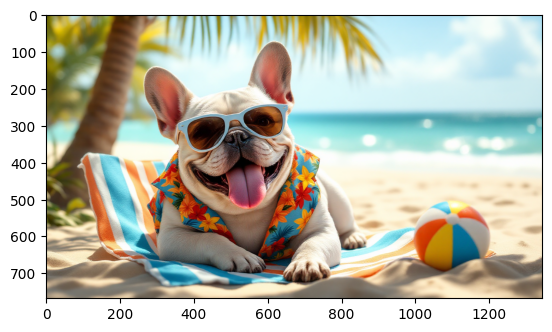

In [12]:
plt.imshow((data['image']*255).numpy().astype(np.uint8).transpose(1, 2, 0))


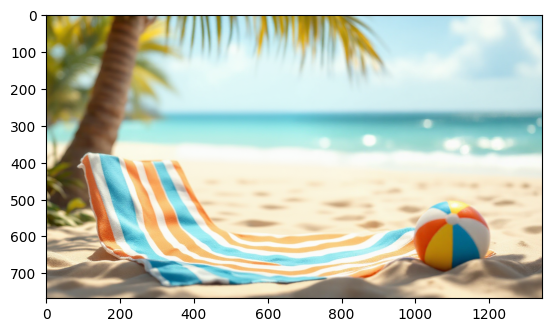

In [13]:
plt.imshow((data['control']*255).numpy().astype(np.uint8).transpose(1, 2, 0))


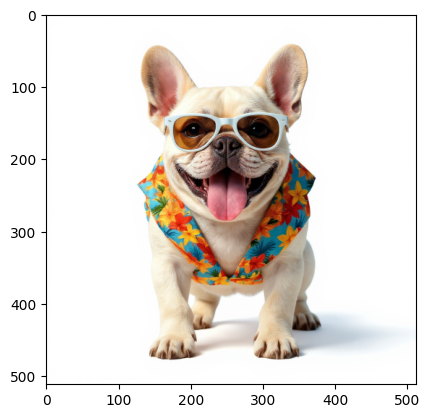

In [14]:
plt.imshow((data['control_1']*255).numpy().astype(np.uint8).transpose(1, 2, 0))


In [13]:
plt.imshow((data['controls'][1]*255).numpy().astype(np.uint8).transpose(1, 2, 0))


IndexError: list index out of range

In [15]:
data['controls'][0].shape

KeyError: 'controls'

In [16]:
plt.imshow((data['controls'][2]*255).numpy().astype(np.uint8).transpose(1, 2, 0))


KeyError: 'controls'

In [17]:
data['prompt']

'Add the character to the image'

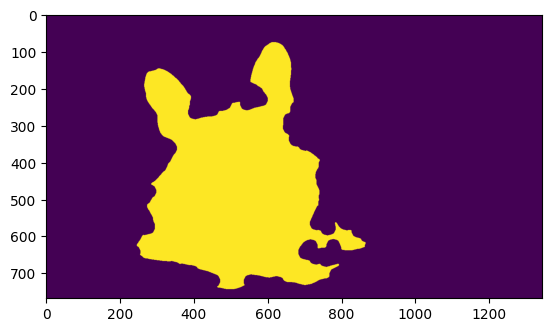

In [18]:
plt.imshow((data['mask'].numpy().astype(np.uint8)))


In [19]:
data['mask'].shape

torch.Size([768, 1344])

In [20]:
data['cached']

False

In [21]:
data['file_hashes']

{'image_hash': '96a6a49b3fa0754278e1e97bf0127f2e',
 'control_hash': '7ac80d2a46bfe85171aae7d6e29e1ed1',
 'prompt_hash': '4c7618c519d796b0df024413434c9358',
 'empty_prompt_hash': 'a2e4822a98337283e39f7b60acf85ec9',
 'control_prompt_hash': '7ac80d2a46bfe85171aae7d6e29e1ed14c7618c519d796b0df024413434c9358',
 'control_empty_prompt_hash': '7ac80d2a46bfe85171aae7d6e29e1ed1a2e4822a98337283e39f7b60acf85ec9',
 'control_1_hash': '075f78615f44d613dc9c771e8866e29f',
 'controls_sum_hash': '7ac80d2a46bfe85171aae7d6e29e1ed1075f78615f44d613dc9c771e8866e29f'}

# cached dataset

In [4]:
config_file='../../tests/test_configs/test_example_fluxkontext_fp4.yaml'
config = load_config_from_yaml(config_file)

In [5]:
config.use_cache

True

In [6]:
config

Config(trainer=<TrainerKind.FluxKontext: 'FluxKontext'>, resume=None, mode=<TrMode.predict: 'predict'>, model=ModelConfig(pretrained_model_name_or_path='eramth/flux-kontext-4bit-fp4', lora=LoraConfig(r=16, lora_alpha=16, init_lora_weights='gaussian', target_modules=['to_k', 'to_q', 'to_v', 'to_out.0'], pretrained_weight=None, adapter_name='lora_edit'), quantize=False), data=DataConfig(class_path='src.data.dataset.ImageDataset', init_args=DatasetInitArgs(dataset_path=[{'split': 'train', 'repo_id': 'TsienDragon/face_segmentation_20'}], caption_dropout_rate=0.1, prompt_image_dropout_rate=0.1, cache_dir='/tmp/image_edit_lora/cache', use_cache=True, use_edit_mask=True, selected_control_indexes=[1], prompt_empty_drop_keys=['prompt_embed', 'pooled_prompt_embed'], processor=ImageProcessorConfig(class_path='src.data.preprocess.ImageProcessor', init_args=ImageProcessorInitArgs(process_type='center_crop', resize_mode='bilinear', target_size=[832, 576], controls_size=[[832, 576]]))), batch_size=8,

In [7]:
dataloader = loader(
        class_path=config.data.class_path,
        init_args=config.data.init_args,
        batch_size=config.data.batch_size,
        num_workers=config.data.num_workers,
        shuffle=config.data.shuffle
    )

缓存已启用，缓存目录: /tmp/image_edit_lora/cache
2025-09-14 00:48:37,286 | INFO | root: Loaded Hugging Face dataset: TsienDragon/face_segmentation_20, {'type': 'huggingface', 'repo_id': 'TsienDragon/face_segmentation_20', 'dataset': Dataset({
    features: ['id', 'control_images', 'control_mask', 'target_image', 'prompt'],
    num_rows: 20
}), 'length': 20, 'start_idx': 0}
2025-09-14 00:48:37,290 | INFO | root: ImageProcessor initialized with target_size: (832, 576)controls_size: [(832, 576)]


In [8]:
for batch in dataloader:
    break
batch['image'].shape, batch['control'].shape, batch['prompt']

(torch.Size([8, 3, 832, 576]),
 torch.Size([8, 3, 832, 576]),
 ['change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask',
  'change the image from the face to the face segmentation mask'])

In [10]:
batch.keys()

dict_keys(['image', 'control', 'prompt', 'file_hashes', 'cached', 'image_latents', 'control_latents', 'pooled_prompt_embed', 'prompt_embed', 'control_ids', 'text_ids', 'image_ids'])

In [11]:
batch['image'].shape

torch.Size([8, 3, 832, 576])

In [12]:
batch['image_latents'].shape

torch.Size([8, 1, 1872, 64])

In [13]:
batch['control_latents'].shape

torch.Size([8, 1, 1872, 64])

In [15]:
batch['prompt_embed'].shape

torch.Size([8, 1, 512, 4096])

In [17]:
batch['text_ids'].shape

torch.Size([8, 512, 3])

In [18]:
batch['image_ids'][0]

tensor([[ 1.,  0.,  0.],
        [ 1.,  0.,  1.],
        [ 1.,  0.,  2.],
        ...,
        [ 1., 51., 33.],
        [ 1., 51., 34.],
        [ 1., 51., 35.]], dtype=torch.float16)

In [19]:
batch['control_ids'][0]

tensor([[ 1.,  0.,  0.],
        [ 1.,  0.,  1.],
        [ 1.,  0.,  2.],
        ...,
        [ 1., 51., 33.],
        [ 1., 51., 34.],
        [ 1., 51., 35.]], dtype=torch.float16)

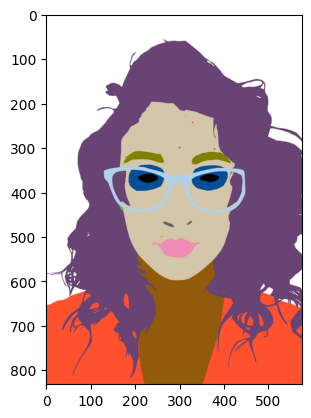

In [21]:
plt.imshow(batch['image'][0].numpy().transpose(1, 2, 0))